In [15]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Pulse Radar Altimeter: Altitude Measurement over Terrain

## Introduction

This notebook demonstrates a **pulse radar altimeter**—a specialized radar system that measures altitude (height above ground or terrain) by transmitting short pulses downward and measuring the time delay of ground reflections. Radar altimeters are critical for aviation, spacecraft landing, terrain-following flight, and autonomous vehicles.

### What is a Radar Altimeter?

**Basic Principle:**

Radar altimeters operate by:

1. **Transmit**: Short burst of RF energy directed downward
2. **Listen**: Receiver waits for ground reflection
3. **Detect**: Measure time delay of returned pulse from terrain
4. **Calculate Altitude**: Convert time to height: $h = \frac{c\tau}{2}$

**Key Characteristics:**

- **Downward-looking**: Antenna beam pointed toward ground
- **High accuracy**: Precise altitude measurement (meter-level)
- **Direct measurement**: Independent of barometric pressure
- **Terrain following**: Continuous altitude tracking over varying terrain

### Altitude Measurement

**Time-Delay Principle:**

The fundamental altitude equation:

$$h = \frac{c \cdot \tau}{2}$$

Where:

- $h$ = Altitude above terrain (m)
- $c$ = Speed of light (3×10⁸ m/s)
- $\tau$ = Round-trip time delay (s)
- Factor 2 accounts for two-way propagation

**Maximum Altitude Range:**

Limited by the pulse repetition frequency (PRF):

$$h_{max} = \frac{c}{2 \cdot PRF} = \frac{c \cdot PRP}{2}$$

For altimeters, this defines the maximum altitude that can be measured unambiguously.

### Altitude Resolution

**Pulse Width Limitation:**

The altitude measurement precision depends on pulse width:

$$\Delta h = \frac{c \cdot T_p}{2}$$

Where:

- $\Delta h$ = Altitude resolution (m)
- $T_p$ = Pulse duration (s)

**Key Trade-off:**

- **Short pulse**: High altitude precision, but less energy
- **Long pulse**: More energy (longer range), but coarser resolution

**Terrain Footprint:**

The altimeter measures a composite return from the terrain footprint:

- Footprint size depends on altitude and antenna beamwidth
- At 4000m altitude with narrow beam: ~140m diameter footprint
- Return represents average terrain elevation within footprint

### Matched Filtering

**Optimal Detection:**

The **matched filter** maximizes signal-to-noise ratio (SNR) by correlating the received signal with a replica of the transmitted pulse:

$$y(t) = \int_{-\infty}^{\infty} x(\tau) \cdot h^*(t-\tau) d\tau$$

Where:

- $x(t)$ = Received signal
- $h(t)$ = Time-reversed and conjugated transmitted pulse
- $y(t)$ = Matched filter output

**Processing Gain:**

Matched filtering provides processing gain:

$$G = B \cdot T_p$$

Where $B$ is the pulse bandwidth and $T_p$ is the pulse duration. For a simple rectangular pulse, $B \cdot T_p \approx 1$, so there is no pulse compression gain, but the filter is still optimal for SNR in white noise.

### Radar Altimeter Advantages

**1. Absolute Altitude:**

- Direct measurement of height above ground
- Independent of barometric pressure/temperature
- Works in any weather conditions

**2. High Accuracy:**

- Meter-level or sub-meter precision
- Real-time continuous measurement
- Unaffected by atmospheric conditions

**3. Terrain Following:**

- Enables low-altitude flight over varying terrain
- Critical for military terrain-following radar
- Autonomous landing systems

**4. Simplicity:**

- Well-understood time-delay principle
- Reliable operation
- Proven technology for aviation safety

### Radar Altimeter Limitations

**1. Terrain Averaging:**

- Measures average height within beam footprint
- Cannot resolve fine terrain details
- Footprint increases with altitude

**2. Specular Reflection:**

- Strong returns from smooth, flat surfaces
- Weak returns from rough terrain or slopes
- Angular sensitivity to terrain orientation

**3. Altitude Range:**

- Minimum altitude: transmit-receive blanking time
- Maximum altitude: limited by power and PRF
- Typical range: 0-5000m for aircraft altimeters

**4. Nadir Requirement:**

- Must be oriented downward (nadir pointing)
- Aircraft attitude affects measurement
- Requires stable platform or correction

### Applications

**Aviation:**

- Commercial aircraft altitude measurement
- Approach and landing guidance
- Low-altitude flight operations
- Decision height callouts

**Military:**

- Terrain-following radar (TFR)
- Low-level penetration missions
- Automatic terrain avoidance
- Helicopter obstacle detection

**Spacecraft:**

- Planetary landing systems (Mars, Moon)
- Orbital altimetry
- Autonomous landing guidance
- Terrain mapping from orbit

**Autonomous Vehicles:**

- Drone altitude control
- UAV landing systems
- Ground clearance measurement
- Obstacle detection

### Altimeter Parameters

**This Example:**

- **Carrier Frequency**: 10 GHz (X-band)
- **Altitude**: 4000 m above terrain
- **Maximum Altitude Range**: 5000 m
- **Altitude Resolution**: 50 m
- **Pulse Width**: ~333 ns
- **PRF**: 30 kHz
- **PRP**: ~33.3 μs
- **Number of Pulses**: 1 (single pulse demonstration)
- **Peak Power**: 1 MW (90 dBm)
- **Sampling Rate**: 6 MHz
- **Antenna**: Downward-pointing (nadir)

### You'll Learn How To:

- Configure pulse radar altimeter for altitude measurement
- Calculate pulse width from altitude resolution requirements
- Set up downward-looking antenna geometry
- Position radar at operational altitude above terrain
- Model complex terrain surface (Grand Canyon 3D model)
- Simulate realistic ground returns with terrain scatter
- Apply matched filtering to extract altitude information
- Generate altitude profile from terrain reflections
- Understand altimeter measurement principles
- Interpret terrain footprint effects on measurements
- Process baseband signals for altitude extraction
- Visualize 3D terrain models and radar geometry

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to demonstrate:

**Altimeter Configuration:**

- 10 GHz X-band pulse altimeter
- 1 MW peak power transmission
- Downward-pointing directional antenna
- Positioned at 4000m altitude

**Terrain:**

- Grand Canyon 3D surface model
- Complex terrain geometry
- Realistic ground scatter
- Large terrain area coverage

**Processing:**

- Matched filtering with pulse replica
- Baseband signal analysis
- Altitude extraction from ground return

**Expected Results:**

- Strong ground return peak at ~4000m range
- Terrain-induced signal spreading
- Demonstration of altitude measurement principle
- Visualization of terrain footprint effects

The simulation demonstrates radar altimeter operation for altitude measurement over complex terrain using RadarSimPy.

## Radar System Configuration

Configure pulse radar altimeter with appropriate waveform parameters for altitude measurement.

### Import Required Modules

Import necessary modules for radar simulation and visualization.

In [16]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Antenna Pattern Definition

Define downward-looking antenna radiation pattern for the altimeter.

**Antenna Characteristics:**

- **Gain**: 20 dBi (directional antenna)
- **Azimuth Pattern**: cos⁵⁰⁰ taper (narrow beam)
- **Elevation Pattern**: cos⁴⁰⁰ taper (narrow beam)
- **Pointing**: Nadir (downward toward ground)
- **Beamwidth**: ~2° (narrow footprint on terrain)

**Altimeter Antenna Design:**

Radar altimeters use:

- Narrow beam to minimize footprint size
- Nadir-pointing orientation (directly downward)
- High gain for strong ground returns
- Low sidelobes to reject off-axis reflections

The narrow beam creates a ~140m diameter footprint on terrain at 4000m altitude, providing good spatial resolution while maintaining adequate signal return.


In [17]:
# Define antenna gain
antenna_gain = 20  # dBi - High-gain directional antenna

### Azimuth Pattern (Horizontal Plane) ###

# Define azimuth angle array: -20° to +20° in 1° steps
az_angle = np.arange(-2, 3, 1)  # 41 points

# Azimuth pattern: cos^500 taper with 20 dBi gain
# Very narrow beamwidth (~2° @ -3dB) with low sidelobes
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi) ** 500) + antenna_gain  # dB

### Elevation Pattern (Vertical Plane) ###

# Define elevation angle array: -20° to +20° in 1° steps
el_angle = np.arange(-2, 3, 1)  # 41 points

# Elevation pattern: cos^400 taper with 20 dBi gain
# Narrow beamwidth (~2.5° @ -3dB)
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi)) ** 400) + antenna_gain  # dB

### Altimeter Waveform Parameters

Calculate pulse altimeter waveform parameters based on altitude measurement requirements.

**Design Requirements:**

1. **Maximum Altitude Range**: 5000 m (typical for aircraft altimeters)
2. **Altitude Resolution**: 50 m (acceptable for general aviation)

**Parameter Derivation:**

From these requirements, we calculate:

**1. Pulse Bandwidth:**

$$B = \frac{c}{2 \Delta h} = \frac{3 \times 10^8}{2 \times 50} = 3 \text{ MHz}$$

**2. Pulse Width:**

$$T_p = \frac{1}{B} = \frac{1}{3,000,000} \approx 333 \text{ ns}$$

**3. Pulse Repetition Frequency (PRF):**

$$PRF = \frac{c}{2h_{max}} = \frac{3 \times 10^8}{2 \times 5000} = 30 \text{ kHz}$$

**4. Pulse Repetition Period (PRP):**

$$PRP = \frac{1}{PRF} = \frac{1}{30,000} \approx 33.3 \text{ μs}$$

**5. Duty Cycle:**

$$\text{Duty Cycle} = \frac{T_p}{PRP} = \frac{333 \times 10^{-9}}{33.3 \times 10^{-6}} = 1\%$$

This is a typical very low duty cycle for pulsed radar, allowing extremely high peak power with reasonable average power.

**Number of Pulses:**

We use **1 pulse** for this demonstration to show fundamental altimeter operation. Real systems typically integrate multiple pulses for improved SNR and measurement stability.


In [18]:
# Import constants
from scipy import constants

# Speed of light constant
light_speed = constants.c  # 299,792,458 m/s

### Calculate Pulsed Radar Waveform Parameters ###

# Performance Requirements
max_range = 5000  # Maximum unambiguous range: 5000 m (5 km)
range_res = 50  # Required range resolution: 50 m

# Derived Waveform Parameters
pulse_bw = light_speed / (2 * range_res)  # Pulse bandwidth: c/(2*ΔR) = 3 MHz
pulse_width = 1 / pulse_bw  # Pulse width: 1/B ≈ 333 ns
prf = light_speed / (2 * max_range)  # PRF: c/(2*R_max) = 30 kHz
prp = 1 / prf  # PRP: 1/PRF ≈ 33.3 μs

# Radar Parameters
fs = 6e6  # Sampling rate: 6 MHz (> 2 × pulse_bw for Nyquist)
fc = 10e9  # Carrier frequency: 10 GHz (X-band)
num_pulse = 1  # Number of pulses: 1 (for single pulse demonstration)

# Calculate sample counts
total_samples = int(prp * num_pulse * fs)  # Total samples in observation
sample_per_pulse = int(total_samples / num_pulse)  # Samples per pulse

### Create Rectangular Pulse Envelope ###

# Create time array for modulation (spans entire observation)
mod_t = np.arange(0, total_samples) / fs  # Time vector (seconds)

# Initialize amplitude modulation array (all zeros initially)
amp = np.zeros_like(mod_t)

# Set pulse-on period: amplitude = 1 for duration of pulse_width
amp[mod_t <= pulse_width] = 1  # Rectangular pulse (first ~333 ns)

### Define Transmitter Channel ###

# Configure TX channel with antenna pattern and pulse modulation
tx_channel = dict(
    location=(0, 0, 0),  # Antenna position at origin
    azimuth_angle=az_angle,  # Azimuth angles array
    azimuth_pattern=az_pattern,  # Azimuth gain pattern (dB)
    elevation_angle=el_angle,  # Elevation angles array
    elevation_pattern=el_pattern,  # Elevation gain pattern (dB)
    amp=amp,  # Pulse amplitude modulation
    mod_t=mod_t,  # Modulation time array
)

### Create Pulsed Radar Transmitter ###

tx = Transmitter(
    f=fc,  # Carrier frequency: 10 GHz
    t=1 / prf,  # Pulse duration: PRP ≈ 33.3 μs
    tx_power=90,  # Transmit power: 90 dBm = 1 MW
    pulses=num_pulse,  # Number of pulses: 1
    channels=[tx_channel],  # Transmitter antenna configuration
)

# Display calculated parameters
print(f"Pulsed Radar Waveform Parameters:")
print(f"  Pulse Width: {pulse_width*1e9:.2f} ns")
print(f"  Pulse Bandwidth: {pulse_bw/1e6:.1f} MHz")
print(f"  PRF: {prf/1e3:.1f} kHz")
print(f"  PRP: {prp*1e6:.2f} μs")
print(f"  Duty Cycle: {(pulse_width/prp)*100:.2f}%")
print(f"  Samples per Pulse: {sample_per_pulse}")
print(f"  Number of Pulses: {num_pulse}")

Pulsed Radar Waveform Parameters:
  Pulse Width: 333.56 ns
  Pulse Bandwidth: 3.0 MHz
  PRF: 30.0 kHz
  PRP: 33.36 μs
  Duty Cycle: 1.00%
  Samples per Pulse: 200
  Number of Pulses: 1


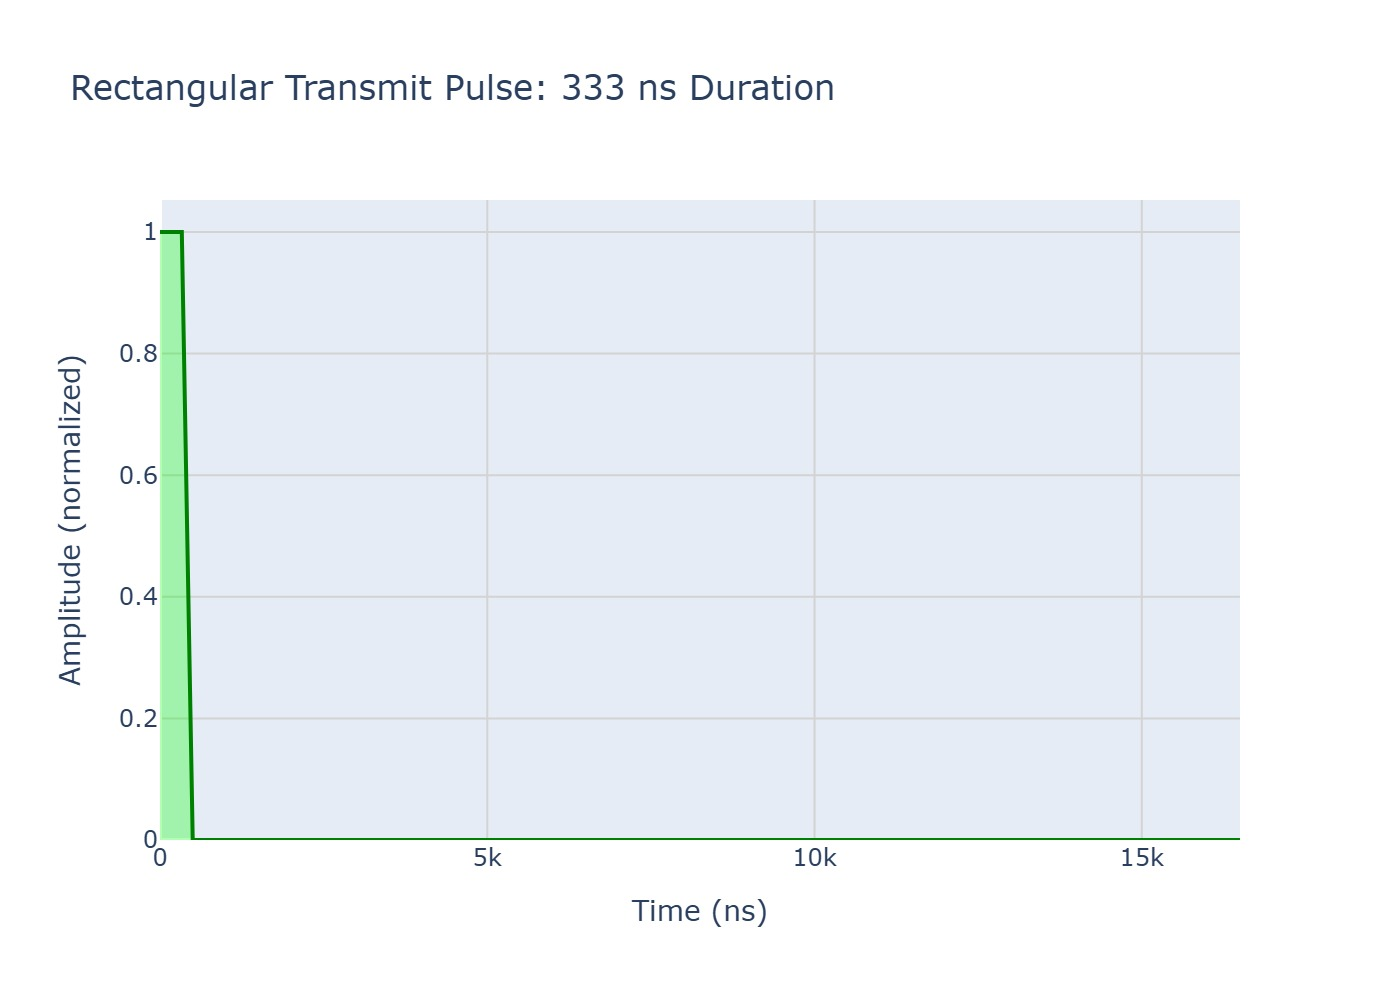

In [19]:
import plotly.graph_objs as go
from IPython.display import Image, display

# Create figure for pulse visualization
fig = go.Figure()

# Plot pulse envelope (first 100 samples to show detail)
fig.add_trace(
    go.Scatter(
        x=mod_t[0:100] * 1e9,  # Convert to nanoseconds
        y=amp[0:100],  # Pulse amplitude
        name="Transmit Pulse",
        line=dict(color="green", width=2),
        fill="tozeroy",
        fillcolor="rgba(0,255,0,0.3)",
    )
)

# Configure plot layout
fig.update_layout(
    title="Rectangular Transmit Pulse: 333 ns Duration",
    yaxis=dict(title="Amplitude (normalized)", gridcolor="lightgray"),
    xaxis=dict(title="Time (ns)", gridcolor="lightgray"),
    height=500,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Receiver Configuration

Configure receiver for baseband sampling and ground return detection.

**Receiver Channel:**

The receiver uses the same antenna pattern as the transmitter for monostatic operation (TX and RX co-located at aircraft position).

**Receiver Parameters:**

- **Sampling Rate**: 6 MHz (exceeds Nyquist for 3 MHz bandwidth)
- **Noise Figure**: 6 dB (standard performance)
- **RF Gain**: 20 dB (LNA amplification)
- **Baseband Gain**: 80 dB (total gain: 100 dB)
- **Load Resistor**: 500 Ω

These parameters are defined through the [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

In [20]:
# Define receiver channel with same antenna pattern (monostatic)
rx_channel = dict(
    location=(0, 0, 0),  # Receiver position at origin (same as TX)
    azimuth_angle=az_angle,  # Same azimuth pattern as TX
    azimuth_pattern=az_pattern,  # Same azimuth gain
    elevation_angle=el_angle,  # Same elevation pattern
    elevation_pattern=el_pattern,  # Same elevation gain
)

In [21]:
# Create pulsed radar receiver
rx = Receiver(
    fs=fs,  # Sampling rate: 6 MHz
    noise_figure=6,  # Noise figure: 6 dB
    rf_gain=20,  # RF gain: 20 dB (LNA)
    load_resistor=500,  # Load resistance: 500 Ω
    baseband_gain=80,  # Baseband gain: 80 dB
    channels=[rx_channel],  # Receiver antenna configuration
)

### Create Radar Altimeter System

Combine transmitter and receiver to form the complete radar altimeter positioned at 4000m altitude, pointing downward.


In [22]:
measurement_time = np.arange(0, 150, 1)  # Time vector for measurement
radar_location = (10000, 30000, 4000)  # Radar location (x, y, z) in meters
radar_speed = (200, 0, 0)  # Radar speed (x, y, z) in m/s

# Create complete pulsed radar system
radar = Radar(
    transmitter=tx,
    receiver=rx,
    location=radar_location,
    speed=radar_speed,
    rotation=(0, -90, 0),
    frame_time=measurement_time,
)  # Monostatic radar at specified location

## Terrain Configuration

Define terrain surface that the altimeter will measure altitude above.

### Terrain Model

**Grand Canyon 3D Model:**

This example uses a detailed 3D mesh model of the Grand Canyon terrain:

- **Model**: STL mesh file with realistic terrain geometry
- **Coverage**: Large terrain area with varying elevation
- **Material**: Ground permittivity εᵣ = 5 (typical soil)

**Altimeter Geometry:**

- **Aircraft Position**: (10000, 30000, 4000) m → 4000m altitude AGL
- **Antenna Orientation**: Pointing downward (nadir, -90° elevation)
- **Terrain Below**: Grand Canyon surface provides complex ground return
- **Range to Terrain**: ~4000m (varies with terrain elevation)

**Expected Behavior:**

The altimeter will receive a composite return from the terrain footprint:

- Main return peak at ~4000m range (altitude above average terrain)
- Signal spreading due to terrain elevation variations within footprint
- Multiple scattering from complex canyon geometry

In [23]:
# Configure Target 1: Terrain model
target_1 = {
    "model": "../models/grand_canyon.stl",  # Terrain 3D model
    "unit": "m",  # Model units in meters
    "location": (0, 0, 0),  # Position: Origin
    "speed": (0, 0, 0),  # Velocity: Stationary
    "permittivity": 5,
}

# Combine targets for simulation
targets = [target_1]

### Visualize Terrain Model

Display the 3D Grand Canyon terrain mesh that the altimeter will measure over.


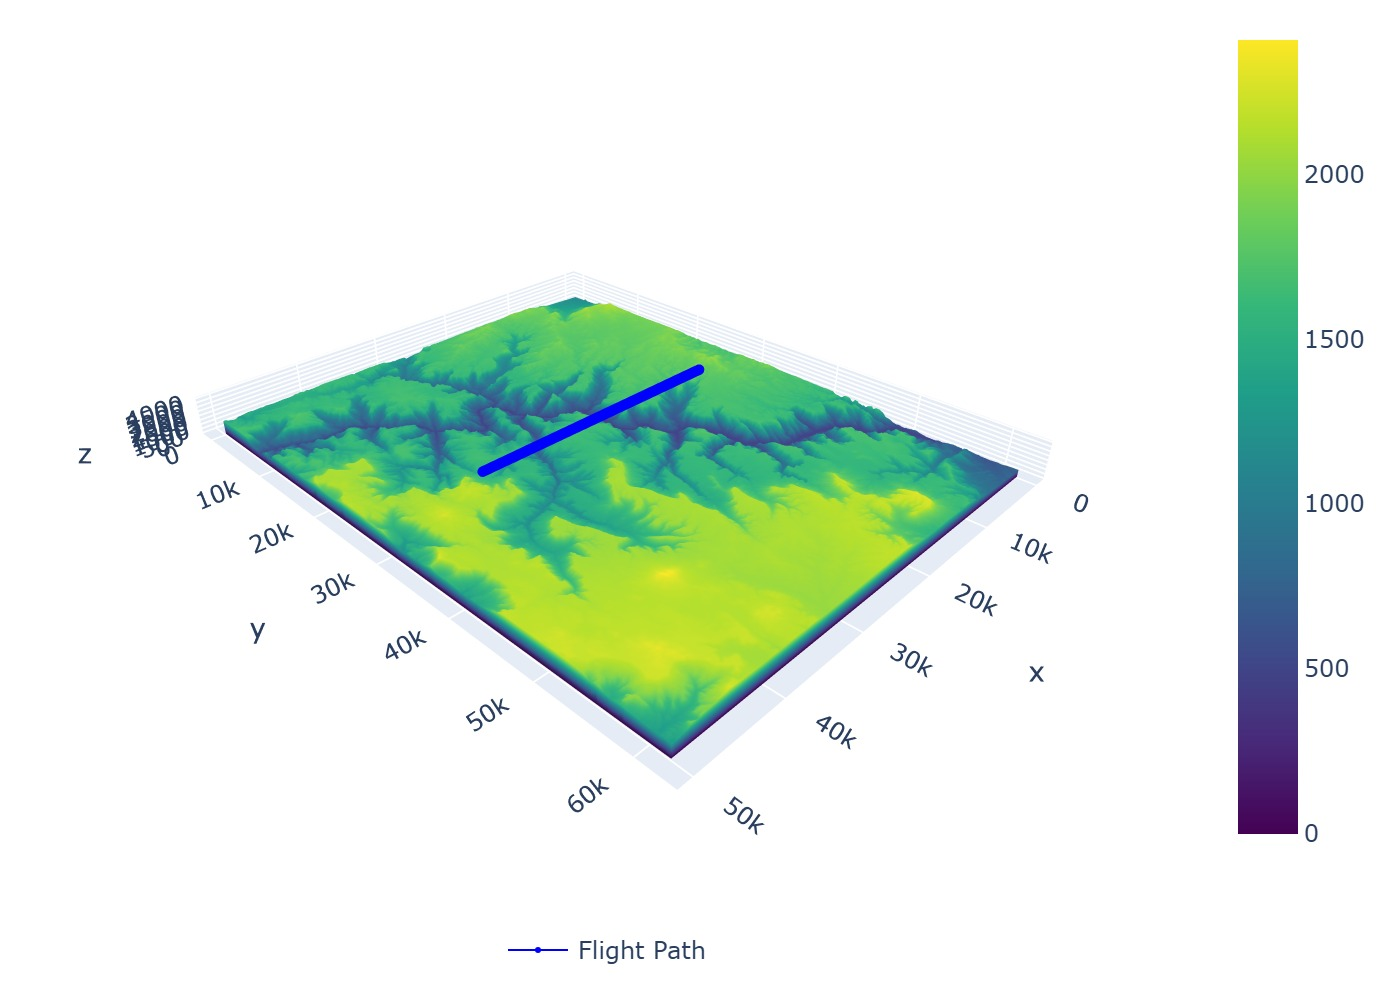

In [24]:
# Import libraries for 3D visualization
import pymeshlab
import plotly.graph_objs as go
from IPython.display import Image

# Load terrain 3D mesh
ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()

# Extract vertex positions and face connectivity
v_matrix = np.array(t_mesh.vertex_matrix())  # Vertex coordinates (N x 3)
f_matrix = np.array(t_mesh.face_matrix())  # Face indices (M x 3)

# Create 3D mesh visualization
fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],  # X coordinates
        y=v_matrix[:, 1],  # Y coordinates
        z=v_matrix[:, 2],  # Z coordinates
        i=f_matrix[:, 0],  # Face vertex indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],  # Color by height
        colorscale="Viridis",  # Color scheme
        name="Terrain",
    )
)

# Add flight path visualization
flight_path_x = radar_location[0] + radar_speed[0] * measurement_time
flight_path_y = radar_location[1] + radar_speed[1] * measurement_time
flight_path_z = radar_location[2] + radar_speed[2] * measurement_time

fig.add_trace(
    go.Scatter3d(
        x=flight_path_x,
        y=flight_path_y,
        z=flight_path_z,
        mode="lines+markers",
        line=dict(color="blue", width=1),
        marker=dict(size=3, color="blue"),
        name="Flight Path",
    )
)

# Configure 3D plot layout with zoomed out camera
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["scene"]["camera"] = dict(
    eye=dict(x=2.5, y=2.5, z=2),  # Zoomed out camera position
    center=dict(x=0, y=0, z=0),
    up=dict(x=0, y=0, z=1),
)
fig["layout"]["height"] = 500  # Plot height in pixels
fig["layout"]["margin"] = dict(
    l=10, r=10, b=30, t=10
)  # Increased bottom margin for legend
fig["layout"]["showlegend"] = True  # Show legend
fig["layout"]["legend"] = dict(
    orientation="h",  # Horizontal orientation
    yanchor="bottom",
    y=-0.15,  # Position below the plot
    xanchor="center",
    x=0.5,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Simulate Baseband Signals

Generate radar altimeter baseband signals with terrain ground return.

### Simulation Process

The simulator performs:

1. **Pulse Transmission**: Single high-power rectangular pulse downward
2. **Propagation**: Calculate time delays to terrain surface elements
3. **Terrain Scatter**: Compute reflections from 3D mesh geometry
4. **Reception**: Down-convert to baseband I/Q
5. **Noise**: Add thermal noise from receiver

**Output Data Structure:**

- **Dimensions**: [channels, pulses, samples]
  - Channels: 1 (single TX/RX)
  - Pulses: 1
  - Samples: ~200 per pulse (6 MHz × 33.3 μs)

**Baseband Signal:**

Complex I/Q data containing:

- Ground return echo from terrain at ~4000m range
- Terrain-induced signal spreading
- Receiver thermal noise
- Pulse envelope shape


In [25]:
# Import radar simulator
from radarsimpy.simulator import sim_radar

# Simulate pulsed radar with terrain target
data = sim_radar(radar, targets, density=0.05)

# Extract simulation results
timestamp = data["timestamp"]  # Time array
baseband = data["baseband"] + data["noise"]  # Complex I/Q + noise

print(f"Simulation complete:")
print(f"  Baseband shape: {baseband.shape}")
print(f"  Number of frames: {baseband.shape[0]}")
print(f"  Samples per pulse: {baseband.shape[2]}")

Simulation complete:
  Baseband shape: (150, 1, 200)
  Number of frames: 150
  Samples per pulse: 200


### Visualize Baseband Signals

Display time-domain I/Q signals showing terrain ground return and noise.


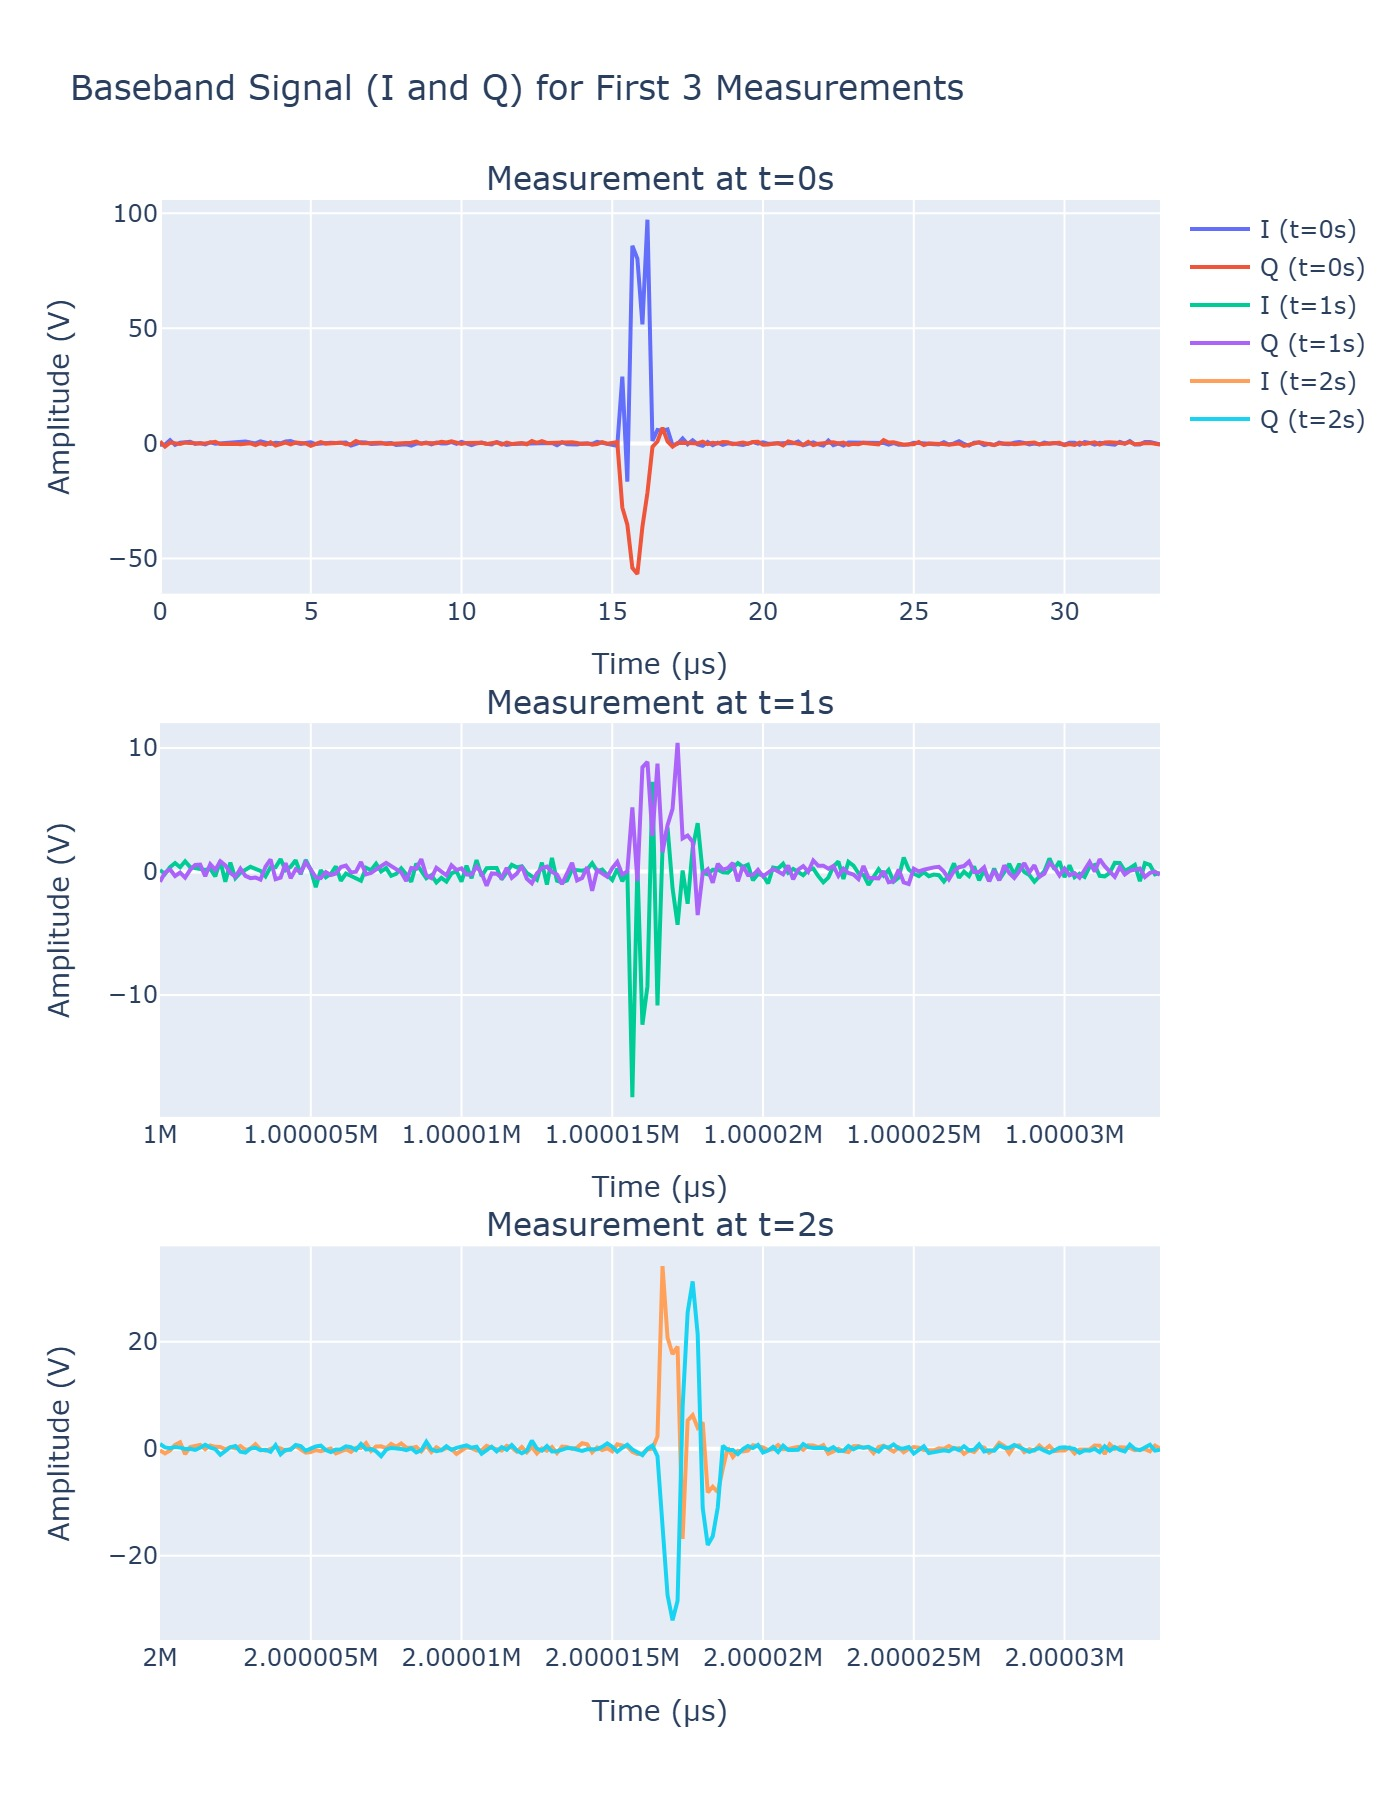

In [26]:
# Plot first 3 baseband signals using subplots
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplots with 3 rows
fig = make_subplots(
    rows=3,
    cols=1,
    subplot_titles=(
        f"Measurement at t={measurement_time[0]:.0f}s",
        f"Measurement at t={measurement_time[1]:.0f}s",
        f"Measurement at t={measurement_time[2]:.0f}s",
    ),
    vertical_spacing=0.09,
)

# Plot first 3 measurements
for idx in range(3):
    t = timestamp[idx, 0, :] * 1e6  # Convert to microseconds
    I = np.real(baseband[idx, 0, :])  # Real part (I channel)
    Q = np.imag(baseband[idx, 0, :])  # Imaginary part (Q channel)

    # Add I channel trace
    fig.add_trace(
        go.Scatter(
            x=t,
            y=I,
            mode="lines",
            name=f"I (t={measurement_time[idx]:.0f}s)",
            # line=dict(color="blue"),
        ),
        row=idx + 1,
        col=1,
    )

    # Add Q channel trace
    fig.add_trace(
        go.Scatter(
            x=t,
            y=Q,
            mode="lines",
            name=f"Q (t={measurement_time[idx]:.0f}s)",
            # line=dict(color="red"),
        ),
        row=idx + 1,
        col=1,
    )

# Update axes labels
for idx in range(3):
    fig.update_xaxes(title_text="Time (μs)", row=idx + 1, col=1)
    fig.update_yaxes(title_text="Amplitude (V)", row=idx + 1, col=1)

# Update layout
fig.update_layout(
    title="Baseband Signal (I and Q) for First 3 Measurements",
    height=900,
    showlegend=True,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Altimeter Signal Processing

Apply matched filtering to extract altitude from terrain ground return.

### Matched Filter Processing

**Matched Filter Theory:**

The matched filter maximizes SNR by correlating the received signal with a replica of the transmitted pulse:

$$y(t) = \int_{-\infty}^{\infty} x(\tau) \cdot h^*(t-\tau) d\tau$$

Where:

- $x(t)$ = Received signal (baseband with terrain return + noise)
- $h(t)$ = Transmitted pulse replica (time-reversed and conjugated)
- $y(t)$ = Matched filter output (altitude profile)

**Processing Gain:**

Matched filtering provides SNR improvement. For a simple rectangular pulse where $B \cdot T_p \approx 1$, there is no pulse compression gain (unlike LFM chirps), but the matched filter is still the optimal linear detector for maximizing SNR in white noise by integrating the signal energy over the pulse duration.

**Altitude Extraction:**

The peak of the matched filter output corresponds to the measured altitude above terrain. The time delay of this peak directly converts to altitude: $h = c\tau/2$.

In [27]:
# Import signal processing module
from scipy import signal

### Apply Matched Filter to Each Pulse ###

# Extract matching coefficients (transmitted pulse shape)
# Use only the non-zero portion of the amplitude array
matchingcoeff = amp[amp != 0]  # Pulse replica for matched filtering

# Initialize range profile storage [frames, pulses, samples]
range_profile = np.zeros_like(baseband, dtype=np.complex128)

for f_idx in range(0, len(measurement_time)):
    # Convolve received signal with pulse replica
    # mode='same' keeps output length same as input
    range_profile[f_idx, 0, :] = signal.convolve(
        baseband[f_idx, 0, :],  # Received baseband for this pulse
        matchingcoeff,  # Transmitted pulse (matched filter)
        mode="same",  # Keep same length as input
    )

print(f"Matched filtering complete:")
print(f"  Matched filter length: {len(matchingcoeff)} samples")
print(f"  Matched Filter SNR Improvement: ~{10*np.log10(len(matchingcoeff)):.1f} dB")
print(f"  Altitude measurement ready for extraction")

Matched filtering complete:
  Matched filter length: 3 samples
  Matched Filter SNR Improvement: ~4.8 dB
  Altitude measurement ready for extraction


### Generate Altitude Profile

Extract altitude information from the matched filter output.

**Altitude Profile:**

The magnitude of the matched filter output shows:

- **Peak location**: Indicates measured altitude (time delay → distance)
- **Peak amplitude**: Indicates ground return strength
- **Signal spreading**: Shows terrain elevation variations within footprint

**Single Pulse Processing:**

For this demonstration, we use a single pulse to show the fundamental measurement. Real altimeters typically:

- Average multiple pulse returns for stability
- Apply tracking filters for smooth altitude output
- Update measurements at high rate (30+ kHz PRF)


### Visualize Altitude Profile

Display the altitude profile showing terrain ground return.

**Interpretation:**

- **X-axis**: Range (m) → Distance from altimeter (altitude)
- **Y-axis**: Amplitude → Ground return strength
- **Main Peak**: Indicates altitude above terrain (~4000m)
- **Signal Spreading**: Shows terrain elevation variations within footprint
- **Noise Floor**: Background noise level

**Processing Chain Summary:**

1. **Matched Filter**: Optimal SNR improvement
2. **Peak Detection**: Identifies altitude measurement
3. **Time to Altitude**: Converts peak location to height

The matched filter enables clear detection of ground return for accurate altitude measurement.

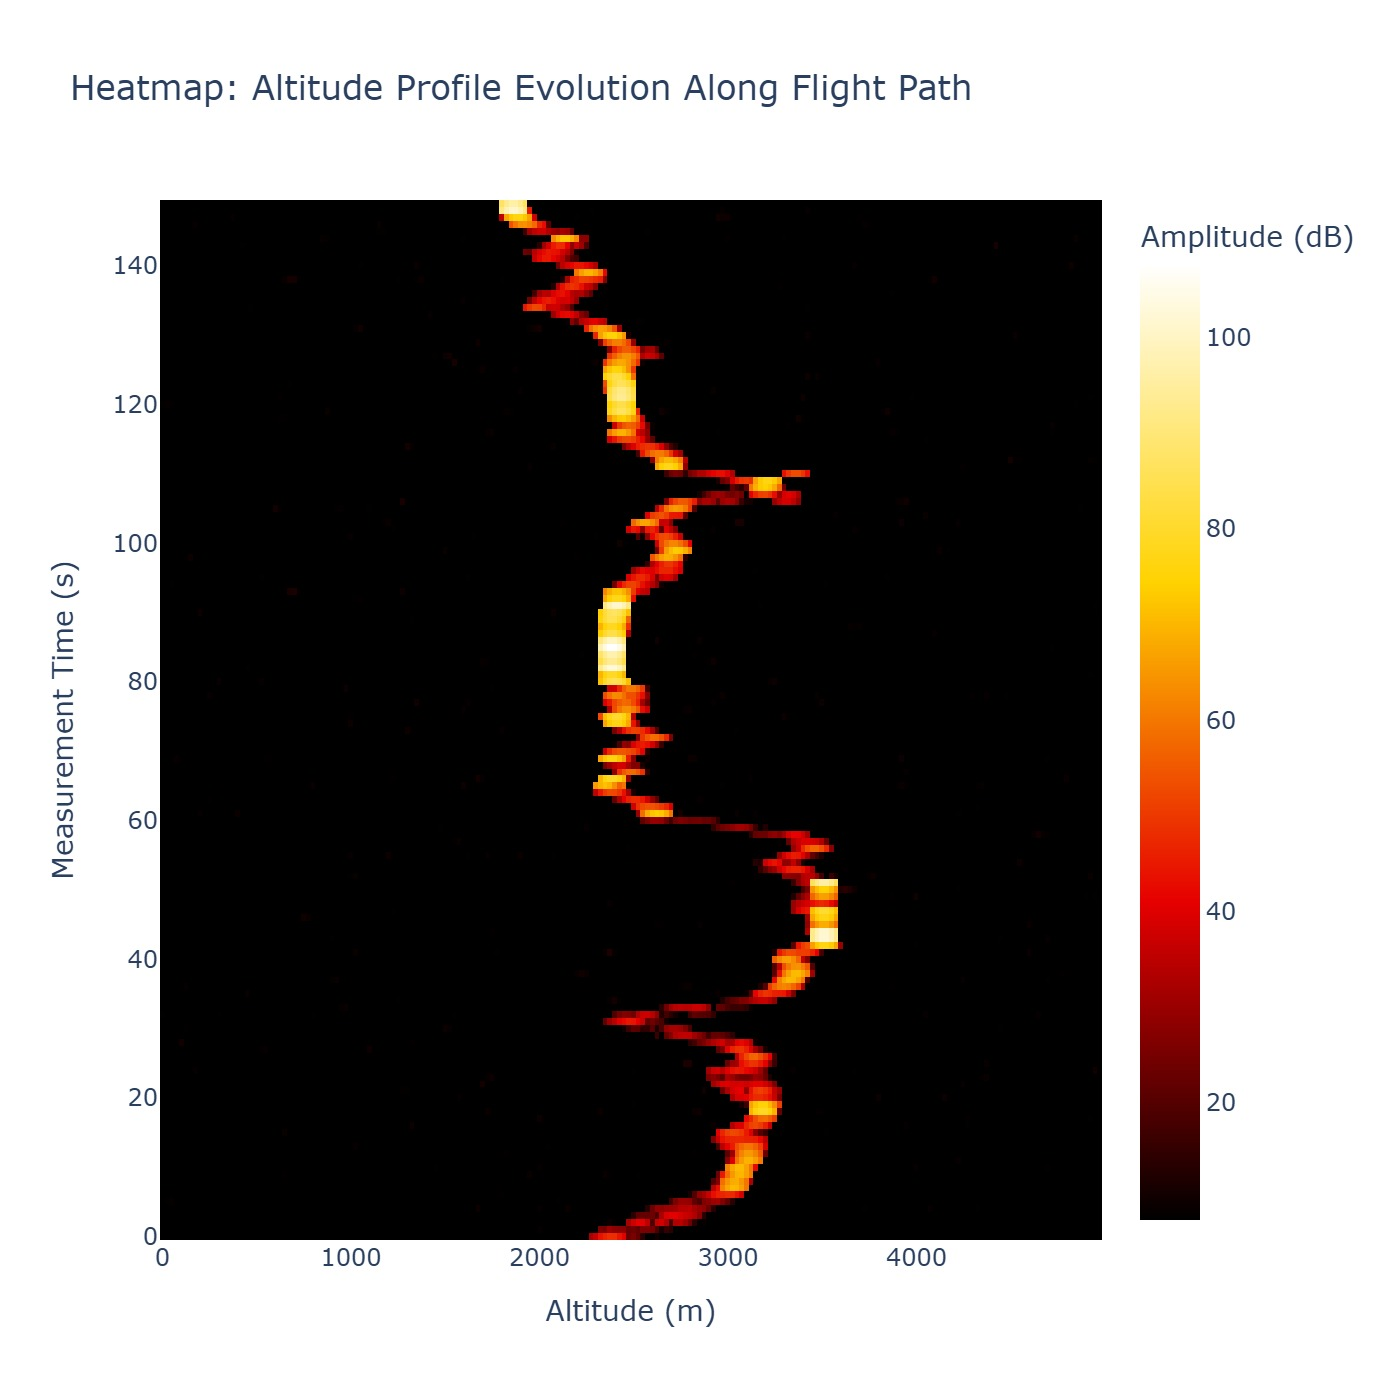

In [33]:
# Create range axis from time (convert to distance)
range_axis = mod_t * light_speed / 2  # Range = c*t/2

# Create heatmap visualization showing range profile evolution along flight path
import plotly.graph_objs as go

# Prepare data for heatmap: rows = measurement times, columns = range bins
n_measurements = len(measurement_time)
heatmap_data = 20 * np.log10(np.abs(range_profile[:, 0, :]))

# Calculate color scale limits: max to max-20
z_max = np.max(heatmap_data)
z_min = z_max - 100

# Create heatmap
fig = go.Figure(
    data=go.Heatmap(
        x=range_axis,
        y=measurement_time,
        z=heatmap_data,
        colorscale="Hot",
        zmin=z_min,
        zmax=z_max,
        colorbar=dict(title="Amplitude (dB)"),
    )
)

# Configure layout
fig.update_layout(
    title="Heatmap: Altitude Profile Evolution Along Flight Path",
    xaxis=dict(title="Altitude (m)", gridcolor="lightgray"),
    yaxis=dict(title="Measurement Time (s)", gridcolor="lightgray"),
    height=700,
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to implement and analyze a pulse radar altimeter using RadarSimPy:

### Key Takeaways

**1. Radar Altimeter Fundamentals**

- Understood altitude measurement principle: h = cτ/2
- Learned downward-pointing geometry (nadir orientation)
- Recognized direct altitude measurement advantage
- Appreciated independence from barometric pressure

**2. Altimeter Waveform Design**

- Calculated pulse width from altitude resolution: Tp = c/(2Δh)
- Determined PRF from maximum altitude: PRF = c/(2hmax)
- Configured for 4000m operational altitude
- Balanced resolution and range requirements

**3. Altitude Resolution**

- Understood pulse width limitation: Δh = c·Tp/2
- Calculated 50m resolution from 333 ns pulse
- Recognized terrain footprint effects (~140m diameter)
- Understood averaging over footprint area

**4. Matched Filtering**

- Implemented optimal filter for altitude extraction
- Applied correlation with transmitted pulse
- Achieved optimal SNR for detection
- Enabled clear ground return detection

**5. Terrain Modeling**

- Loaded complex 3D terrain geometry (Grand Canyon)
- Positioned aircraft at 4000m altitude
- Simulated realistic ground scatter
- Observed terrain-induced signal spreading

**6. Downward-Looking Antenna**

- Configured narrow beam (cos⁵⁰⁰, cos⁴⁰⁰) pointing downward
- Achieved 20 dBi gain for strong ground returns
- Created ~140m terrain footprint at 4000m altitude
- Minimized off-nadir reflections

**7. Altitude Measurement**

- Detected ground return peak at ~4000m range
- Extracted altitude from time delay measurement
- Observed composite return from terrain footprint
- Demonstrated fundamental altimeter operation

**8. Signal Processing Chain**

- Simulated baseband I/Q signals with terrain return
- Applied matched filtering for SNR improvement
- Generated altitude profile from ground echo
- Achieved clear detection of terrain return

### Experiment Further

Try modifying the parameters to explore different altimeter scenarios:

**1. Altitude Resolution**:

- Vary range_res: 10m, 100m, 200m
- Observe pulse width changes: Tp ∝ Δh
- Test precision requirements
- Balance resolution and signal strength

**2. Operating Altitude**:

- Change radar altitude: 1000m, 2000m, 8000m
- Observe signal delay changes
- Test maximum altitude capability
- Understand footprint size variation

**3. Antenna Beamwidth**:

- Wider beam: cos¹⁰⁰ (larger footprint)
- Narrower beam: cos¹⁰⁰⁰ (smaller footprint)
- Observe terrain averaging effects
- Trade off gain vs. footprint size

**4. Carrier Frequency**:

- Test 4 GHz (C-band), 35 GHz (Ka-band)
- Observe atmospheric effects
- Compare terrain penetration
- Understand frequency selection for altimeters

**5. Terrain Type**:

- Try different 3D models (flat, mountainous)
- Observe signal spreading variations
- Test over smooth vs. rough terrain
- Understand terrain effects on measurement

**6. Peak Power**:

- Vary tx_power: 50 dBm, 70 dBm, 80 dBm
- Observe maximum altitude capability
- Test SNR improvements
- Understand power requirements

**7. Pulse Integration**:

- Increase num_pulse: 10, 50, 100
- Implement averaging for stability
- Observe noise reduction
- Simulate real altimeter operation

**8. Sampling Rate**:

- Vary fs: 3 MHz, 12 MHz, 20 MHz
- Observe altitude precision
- Test Nyquist criterion (fs > 2B)
- Balance accuracy vs. processing load

**9. Antenna Orientation**:

- Test slight off-nadir angles
- Observe signal strength changes
- Understand attitude sensitivity
- Require stable platform importance

**10. Material Properties**:

- Vary terrain permittivity: 3, 10, 80 (water)
- Observe return strength changes
- Test over different surfaces
- Understand material effects on radar

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- Radar Altimeters: Time-delay altitude measurement
- Matched Filtering: Optimal signal processing for altitude extraction
- Terrain Following Radar: Military low-altitude flight systems
- Aviation Altimeters: Commercial aircraft altitude measurement
- Planetary Landing: Spacecraft altimeter systems
- Autonomous Landing: UAV/drone altitude control
- Antenna Patterns: Downward-looking beam design
- Terrain Effects: Ground scatter and footprint analysis